# Tomo_3_refinement_minor_phase
## Tomographic refinement notebook  
__Written by Haixing Fang, Jon Wright and James Ball__  
__Date: 21/02/2025__

This notebook will try to perform a point-by-point strain refinement from your tomographic-derived grain shapes.  

### NOTE: It is highly recommended to run this notebook on a Jupyter server with many cores and a lot of RAM.  
The compute_origins() function in particular runs locally and can be compute-intensive for large datasets.  
If this is a big scan (e.g 100 million+ 2D peaks), you should definitely refine on the cluster rather than locally.

In [1]:
import os

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

In [2]:
exec(open('/data/id11/nanoscope/install_ImageD11_from_git.py').read())

Change : 
1. the dataset name (`dset_path`)
2. the phase name (`phase_str`)

In [3]:
# this cell is tagged with 'parameters'
# to view the tag, select the cell, then find the settings gear icon (right or left sidebar) and look for Cell Tags

# python environment stuff
PYTHONPATH = setup_ImageD11_from_git( os.path.join( os.environ['HOME'],'Code', 'Tutorial', 'SCRIPTS'), 'ImageD11' )# ( os.path.join( os.environ['HOME'],'Code'), 'ImageD11_git' )

# dataset file to import
dset_path = '../FeAu_0p5_tR_nscope/FeAu_0p5_tR_nscope_top_200um/FeAu_0p5_tR_nscope_top_200um_dataset.h5'

# which phase to index
phase_str = 'Au'

# default options for the single-valued map (shouldn't need to modify this)
default_npks = 20
default_nuniq = 20

# refinement tolerances
hkl_tol_origins = 0.05
hkl_tol_refine = 0.1
hkl_tol_refine_merged = 0.05
ds_tol = 0.005
ifrac = 7e-3
rings_to_refine = None  # can be a list of rings

# use cluster for refinement or run locally?
use_cluster = False

# Setting path via: 
sys.path.insert(0, /home/esrf/ljegou/Code/Tutorial/SCRIPTS/ImageD11 )
# Running from: /home/esrf/ljegou/Code/Tutorial/SCRIPTS/ImageD11/ImageD11/__init__.py


In [4]:
import os

import numpy as np
import matplotlib.pyplot as plt

import ImageD11.sinograms.dataset
from ImageD11.sinograms.sinogram import read_h5
from ImageD11.sinograms.tensor_map import TensorMap
from ImageD11.sinograms.point_by_point import PBPRefine

import ImageD11.nbGui.nb_utils as utils
# %matplotlib ipympl

# Load data
1. The dataset
2. The phases
3. The grains
4. The tensormaps

## Dataset

In [5]:
ds = ImageD11.sinograms.dataset.load(dset_path)
print(ds)

dataroot = "/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/RAW_DATA"
analysisroot = "/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/PROCESSED_DATA/20250626_LJ"
sample = "FeAu_0p5_tR_nscope"
dset = "top_200um"
shape = ( 275, 1448)
# scans 275 from 1.1 to 275.1


## Phases
If the parameter file was a json, we can access the unit cells via `ds.phases.unitcells`

In [6]:
ds.phases = ds.get_phases_from_disk()
ds.phases.unitcells

{'Au': Au | [ 4.005  4.005  4.005 90.    90.    90.   ] | 225,
 'Fe': Fe | [ 2.8694  2.8694  2.8694 90.     90.     90.    ] | 229,
 'B2': B2 | [ 3.8867  3.8867  3.8867 90.     90.     90.    ] | 221,
 'CeO2': CeO2 | [ 5.41143  5.41143  5.41143 90.      90.      90.     ] | F}

In [7]:
ucell = ds.phases.unitcells[phase_str]
print(ucell)

Au | [ 4.005  4.005  4.005 90.    90.    90.   ] | 225


## Peaks

This time, 2D peaks are loaded instead of 4D peaks. 4D peaks correspond to merged 2D peaks. When the sample is moving across the beam, big grains might produce the same diffraction spot at different positions of the sample. Thus, 2D peaks contains much more peaks than 4D peaks, which will be use to refine the grain reconstruction.  

In [8]:
cf_2d = ds.get_cf_2d()
ds.update_colfile_pars(cf_2d)  # computes geometry, needed for filtration
print(f"Read {cf_2d.nrows} 2D peaks")

Read 11983726 2D peaks


## Grains

In [9]:
grainsinos = read_h5(ds.grainsfile, ds, phase_str)
grains = [gs.grain for gs in grainsinos]

## TensorMap

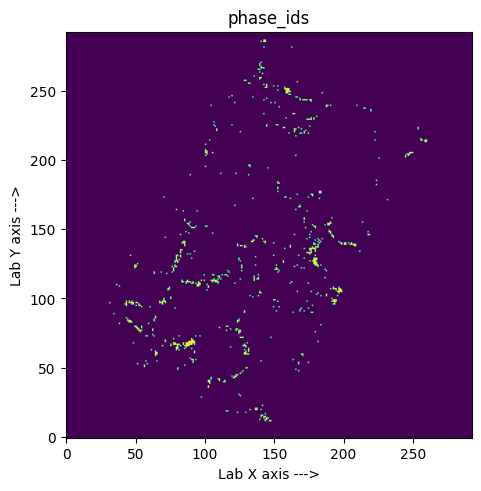

In [10]:
tensor_map = TensorMap.from_h5(ds.grainsfile, h5group='TensorMap_' + phase_str)
tensor_map.plot('phase_ids')

Make a PBPMap (Point By Point Map) from our TensorMap
A PBPMap is a map where each pixel is associated to one single UBI (whereas a tensor map after the tomographic reconstruction is a map of different grains where each grain has a unique UBI, so no misorientation within a grain).

Fills voxels that have grains with `npks = 20` and `nuniq = 20`

In [11]:
pmap = tensor_map.to_pbpmap(z_layer=0, default_npks=default_npks, default_nuniq=default_nuniq)

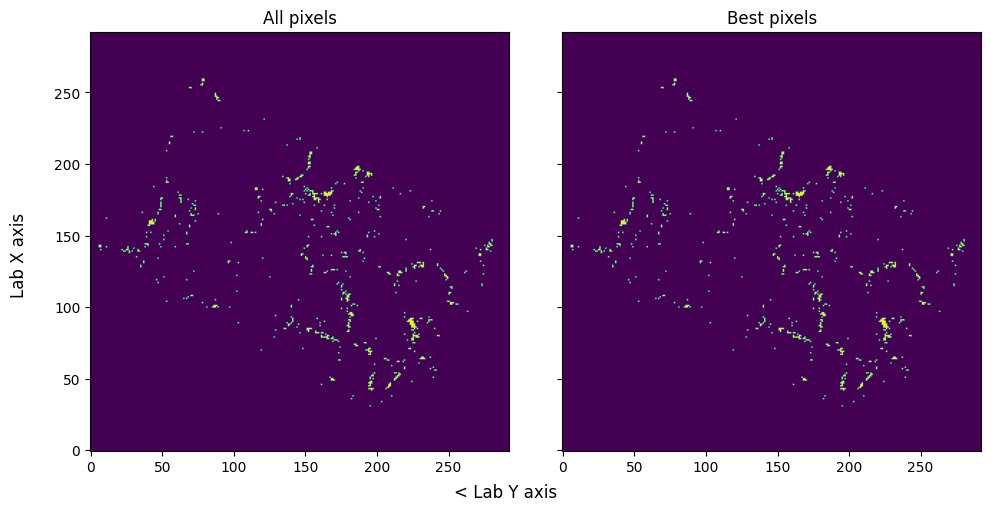

In [12]:
pmap.choose_best(1)
pmap.plot_best(1)

# Refinement

You can play on different parameters during the refinement : 
- `hkl_tol_origins`: the *hkl* tolerance on @@@,
- `hkl_tol_refine`: the *hkl* tolerance on @@@,
- `hkl_tol_refine_merged`: the *hkl* tolerance on @@@,
- `ds_tol`: the $d^{*}$ tolerance,
- `ifrac`: the intensity fraction of the selected peaks,
- `phase_str`: the name of the phase to refine (the same notebook is used for the major and the minor phases),
- `rings_to_refine`: the rings on which to do the refinement. *None* by default, but you can select a list of specific rings if strong overlaps occur between different phases.

In [13]:
# set up a refinement manager object
y0 = grainsinos[0].recon_y0
refine = PBPRefine(dset=ds, y0=y0, hkl_tol_origins=hkl_tol_origins, hkl_tol_refine=hkl_tol_refine, hkl_tol_refine_merged=hkl_tol_refine_merged, ds_tol=ds_tol, ifrac=ifrac, phase_name=phase_str, forref=rings_to_refine)
# change the default paths of the refinement manager to append the phase name
refine.own_filename = os.path.splitext(refine.own_filename)[0] + f'_{phase_str}.h5'
refine.icolf_filename = os.path.splitext(refine.icolf_filename)[0] + f'_{phase_str}.h5'
refine.pbpmap_filename = os.path.splitext(refine.pbpmap_filename)[0] + f'_{phase_str}.h5'
refine.refinedmap_filename = os.path.splitext(refine.refinedmap_filename)[0] + f'_{phase_str}.h5'

In [14]:
# tell it which point-by-point map we are refining
refine.setmap(pmap)

# or load from disk:
# refine.loadmap()

set the mask from minimum peak values
anything greater than 0 should be accepted

In [15]:
refine.mask = pmap.best_npks > 0

generate a single-valued map to refine on

In [16]:
refine.setsingle(refine.pbpmap, minpeaks=1)

choose 2D peaks to refine with
or load from disk:
```
refine.loadpeaks()
```

In [17]:
refine.setpeaks(cf_2d)

I will delete an existing refined peaks H5 file if I find it on disk!
Waiting 10 seconds for you to interrupt this if you are unhappy
Continuing
To disable this prompt, set prompt_del=False when calling setpeaks()
0 0.4325 (1, 1, 1) 8 15908 used, sum_intensity> 183.10968738548544
1 0.4994 (0, 2, 0) 6 14534 used, sum_intensity> 157.17897518264638
2 0.7062 (0, 2, 2) 12 20900 used, sum_intensity> 60.47791424213851
3 0.8281 (1, 3, 1) 24 29312 used, sum_intensity> 45.874206934296794
4 0.8649 (2, 2, 2) 8 10958 used, sum_intensity> 36.66275651995608
5 0.9988 (4, 0, 0) 6 6790 used, sum_intensity> 26.08950978493854
6 1.0884 (3, 1, 3) 24 20074 used, sum_intensity> 18.885490060557423
7 1.1166 (4, 2, 0) 24 15932 used, sum_intensity> 24.966159367185547
8 1.2232 (4, 2, 2) 24 9427 used, sum_intensity> 33.514339684277374
9 1.2974 (1, 5, 1) 32 49579 used, sum_intensity> 389.52420316769684
10 1.4124 (4, 0, 4) 12 7433 used, sum_intensity> 12.874928403559656
11 1.4772 (3, 5, 1) 48 322016 used, sum_intensi

## Setting up peaks

Plot the peaks you selected.

(<Figure size 640x480 with 3 Axes>,
 array([<Axes: xlabel='$d^{*}~(\\AA^{-1})$', ylabel='sum intensity'>,
        <Axes: xlabel='$\\omega~(\\degree)$', ylabel='dty'>], dtype=object))

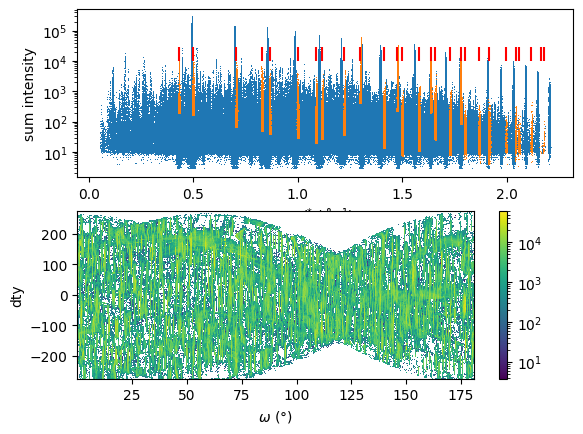

In [18]:
refine.iplot()

## Compute peak diffraction origins

Compute diffraction origins - these will be added as a column to refine.icolf.
Will then save the new column to disk to avoid re-computation.

In [19]:
refine.get_origins()

Getting gvecs...
Running test function twice for the first 10000 peaks to guess speed...
This is because we get speed advantages with peaks on consecutive frames
First time to trigger NJIT
Now we time
I estimate roughly 0.36452824566125963 seconds for all peaks in self.icolf
That's 0.00010125784601701657 hours
Lexsort...
Running numba computation on 39 threads, may take a while!
xpos_refined column added to self.icolf
Saving self.icolf to disk with new column


## Run refinement

Run the refinement
If compute_origins took more than a couple of minutes to run, we suggest setting 
```
use_cluster=True 
```

otherwise if you asked for lots of cores and RAM on this Jupyter instance, you can run it locally 
```
use_cluster=False
```

In [20]:
refine.run_refine(use_cluster=use_cluster, pythonpath=PYTHONPATH)

Launching Numba parallel refinement on 39 threads
Saving refined map to disk


# Export

Save the results

In [21]:
if not use_cluster:
    refine.to_h5()
ds.save()

Saving icolf to disk
Saving input map to disk
Saving output map to disk
Saving myself to disk
